# SWB Reaction Time Analysis 

CHECK MODEL FN # not necessary if we use a different python function for linear regression! HOWEVER, now confused about the intercept thing so going to keep using skikit-learn for now (which means we need this function)
ols = sm.OLS(y_train, sm.add_constant(X_train)).fit() stats models fn WITH intercept 

In [1]:
import numpy as np
import matplotlib.pyplot as plt #if matplotlib error - uninstall all matplotlib and pillow versions and conda install pillow==9.4.0
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
import random
import os
import sklearn
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

from statsmodels.regression.mixed_linear_model import MixedLM



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/scripts/python_pipeline/')
import SWB_behav_utils

In [4]:
swb_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
raw_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_raw/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'
fig_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/figures/'
# get date info for data/fig saving
date = datetime.date.today().strftime('%m%d%Y')
print(date)

05302024


In [5]:
# subj_list = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='Master_List', usecols=[0])
subj_list = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID.tolist()
subj_ids = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID.tolist()
# subj_list = list(subj_list.PatientID)
subj_ids

bdi_list = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
list(zip(subj_ids,bdi_list))


[('MS002', 14),
 ('MS003', 8),
 ('MS009', 16),
 ('MS011', 13),
 ('MS015', 26),
 ('MS016', 10),
 ('MS017', 26),
 ('MS019', 12),
 ('MS022', 10),
 ('MS024', 16),
 ('MS025', 10),
 ('MS026', 9),
 ('MS027', 22),
 ('MS028', 13),
 ('MS029', 32),
 ('MS030', 19),
 ('MS033', 39),
 ('MS035', 15),
 ('MS041', 10),
 ('MS043', 23),
 ('DA8', 13),
 ('DA023', 14),
 ('DA026', 19)]

In [52]:
all_behav = pd.concat([pd.read_csv(f'{behav_dir}{subj_id}_task_data').assign(subj_id = subj_id) for subj_id in subj_ids]).reset_index(drop=True)
all_behav

Round  Trial Num TrialType   TrialOnset  ChoiceOnset  DecisionOnset  \
0         1       25.0       mix   513.380590   513.390239     515.450091   
1         2      117.0      loss   522.640856   522.641563     524.596127   
2         3       79.0      gain   531.174799   531.175599     532.759061   
3         4       42.0       mix   545.592613   545.593355     548.084966   
4         5       85.0      gain   555.337336   555.345720     557.114656   
...     ...        ...       ...          ...          ...            ...   
3447    146       71.0      gain  2349.009236  2349.014485    2352.033710   
3448    147       91.0      gain  2358.784736  2358.788842    2362.095848   
3449    148       93.0      gain  2374.757244  2374.757517    2378.421736   
3450    149       10.0       mix  2385.833929  2385.848527    2388.083992   
3451    150       34.0       mix  2395.021701  2395.021969    2400.312198   

      FeedbackOnset        RT  SafeBet  LowBet  ...  decisionCPE totalRegret  \
0        515.457173  2.059852      0.0   -1.10  ...        -0.57       -0.57   
1        526.627092  1.954564     -0.3   -0.95  ...        -0.65       -0.95   
2        534.780269  1.583462      0.4    0.00  ...         1.28        0.00   
3        548.092333  2.491611      0.0   -0.80  ...         0.80        0.00   
4        559.135069  1.768936      0.5    0.00  ...         0.74        0.00   
...             ...       ...      ...     ...  ...          ...         ...   
3447    2354.049841  3.019225      0.4    0.00  ...         0.27        0.00   
3448    2362.102955  3.307006      0.6    0.00  ...         0.60        0.00   
3449    2378.432645  3.664220      0.6    0.00  ...        -0.60       -0.60   
3450    2388.093773  2.235465      0.0   -0.50  ...        -0.20       -0.20   
3451    2402.328758  5.290229      0.0   -1.50  ...         1.50        0.00   

     decisionRegret totalRelief decisionRelief totalCF  decisionCF   pRPE  \
0             -0.57        0.00           0.00    0.57        0.57  0.000   
1             -0.65        0.00           0.00    0.00       -0.30  0.000   
2              0.00        1.68           1.28    0.00        0.40  0.840   
3              0.00        0.80           0.80   -0.80       -0.80  0.000   
4              0.00        1.24           0.74    0.00        0.50  0.620   
...             ...         ...            ...     ...         ...    ...   
3447           0.00        0.67           0.27    0.00        0.40  0.335   
3448           0.00        0.60           0.60    0.00        0.00  0.000   
3449          -0.60        0.00           0.00    1.20        1.20  0.000   
3450          -0.20        0.00           0.00    0.20        0.20  0.000   
3451           0.00        3.00           1.50   -1.50        0.00  1.500   

       nRPE  subj_id  
0     0.000    MS002  
1    -0.475    MS002  
2     0.000    MS002  
3     0.000    MS002  
4     0.000    MS002  
...     ...      ...  
3447  0.000    DA026  
3448  0.000    DA026  
3449  0.000    DA026  
3450  0.000    DA026  
3451  0.000    DA026  

[3452 rows x 33 columns]

In [53]:
roundt1 = []
logRT = []
logRTt1 = []
choicet1 = []
gamEVt1 = []

for subj_id in subj_ids:

    rounds_t1 = list(all_behav.Round[all_behav.subj_id == subj_id]+1)
    logRT_list = np.log(all_behav.RT[all_behav.subj_id == subj_id]).tolist() # take log of RT
    logRT_t1_list = logRT_list[1:] # get logRT_t1
    logRT_t1_list.append(np.nan) # add nan to logRT_t1 (no t1 for last round)
    roundt1.extend(rounds_t1)
    logRT.extend(logRT_list)
    logRTt1.extend(logRT_t1_list)
    choices = all_behav[all_behav.subj_id == subj_id].GambleChoice.tolist()
    t1choices = choices[1:]
    t1choices.append(np.nan)
    choicet1.extend(t1choices)
    evs = all_behav[all_behav.subj_id == subj_id].GambleEV.tolist()
    t1evs = evs[1:]
    t1evs.append(np.nan)

    gamEVt1.extend(t1evs)
    

In [54]:
all_behav['Round_t1'] = roundt1
all_behav['logRT'] = logRT
all_behav['logRT_t1'] = logRTt1
all_behav['choice_t1'] = choicet1
all_behav['gamEV_t1'] = gamEVt1

In [55]:
sum(all_behav.RT<0.3)

130

In [56]:
#### FILTER BAD BEHAV + RTS
all_behav = all_behav[all_behav.RT>0.3]
all_behav = all_behav[(all_behav.GambleChoice=='gamble') | (all_behav.GambleChoice == 'safe')].reset_index(drop=True)
all_behav = all_behav[(all_behav.choice_t1=='gamble') | (all_behav.choice_t1 == 'safe')].reset_index(drop=True)
all_behav = all_behav[(all_behav.Outcome=='good') | (all_behav.Outcome == 'bad')].reset_index(drop=True)
all_behav = all_behav[all_behav.Round != 76]
all_behav = all_behav[all_behav.Round_t1 != 76]
all_behav = all_behav[~np.isinf(all_behav.logRT_t1)]
all_behav['GambleChoice'] = all_behav['GambleChoice'].astype('category')
all_behav['choice_t1']    = all_behav['choice_t1'].astype('category')
all_behav['TrialType']    = all_behav['TrialType'].astype('category')
all_behav

Round  Trial Num TrialType   TrialOnset  ChoiceOnset  DecisionOnset  \
0         1       25.0       mix   513.380590   513.390239     515.450091   
1         2      117.0      loss   522.640856   522.641563     524.596127   
2         3       79.0      gain   531.174799   531.175599     532.759061   
3         4       42.0       mix   545.592613   545.593355     548.084966   
4         5       85.0      gain   555.337336   555.345720     557.114656   
...     ...        ...       ...          ...          ...            ...   
3239    145       89.0      gain  2338.790304  2338.794819    2341.788305   
3240    146       71.0      gain  2349.009236  2349.014485    2352.033710   
3241    147       91.0      gain  2358.784736  2358.788842    2362.095848   
3242    148       93.0      gain  2374.757244  2374.757517    2378.421736   
3243    149       10.0       mix  2385.833929  2385.848527    2388.083992   

      FeedbackOnset        RT  SafeBet  LowBet  ...  totalCF decisionCF  \
0        515.457173  2.059852      0.0   -1.10  ...     0.57       0.57   
1        526.627092  1.954564     -0.3   -0.95  ...     0.00      -0.30   
2        534.780269  1.583462      0.4    0.00  ...     0.00       0.40   
3        548.092333  2.491611      0.0   -0.80  ...    -0.80      -0.80   
4        559.135069  1.768936      0.5    0.00  ...     0.00       0.50   
...             ...       ...      ...     ...  ...      ...        ...   
3239    2341.795366  2.993486      0.5    0.00  ...     2.10       2.10   
3240    2354.049841  3.019225      0.4    0.00  ...     0.00       0.40   
3241    2362.102955  3.307006      0.6    0.00  ...     0.00       0.00   
3242    2378.432645  3.664220      0.6    0.00  ...     1.20       1.20   
3243    2388.093773  2.235465      0.0   -0.50  ...     0.20       0.20   

       pRPE   nRPE subj_id Round_t1     logRT  logRT_t1  choice_t1  gamEV_t1  
0     0.000  0.000   MS002        2  0.722634  0.670167     gamble    -0.475  
1     0.000 -0.475   MS002        3  0.670167  0.459614     gamble     0.840  
2     0.840  0.000   MS002        4  0.459614  0.912929       safe     0.200  
3     0.000  0.000   MS002        5  0.912929  0.570378     gamble     0.620  
4     0.620  0.000   MS002        6  0.570378  0.631657       safe    -0.185  
...     ...    ...     ...      ...       ...       ...        ...       ...  
3239  0.000  0.000   DA026      146  1.096439  1.105000     gamble     0.335  
3240  0.335  0.000   DA026      147  1.105000  1.196043       safe     0.505  
3241  0.000  0.000   DA026      148  1.196043  1.298615       safe     0.600  
3242  0.000  0.000   DA026      149  1.298615  0.804449       safe    -0.150  
3243  0.000  0.000   DA026      150  0.804449  1.665862     gamble     0.000  

[3147 rows x 38 columns]

In [57]:
cols_to_zscore = ['Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']

zscore_df = []

for subj_id in subj_ids:
    subj_zdf = pd.DataFrame({f'{col}':zscore(all_behav[col][all_behav.subj_id == subj_id]) for col in cols_to_zscore})
    zscore_df.append(subj_zdf)

In [58]:
zscore_df[0]

Profit  TotalProfit  GambleEV        CR  choiceEV       RPE  totalCPE  \
0   -0.101071    -2.052467 -0.475216  0.132859 -0.215499 -0.038143 -0.586407   
1   -1.784569    -2.680443 -0.856666  0.132859 -1.577821 -1.144303 -0.930361   
2    2.876062    -1.569917  1.531940  0.132859  2.193660  1.918013  1.450161   
3   -0.101071    -1.569917  0.369424  0.132859 -0.215499 -0.038143  0.653637   
4    2.096336    -0.750243  1.132326  0.132859  1.562690  1.405686  1.051899   
..        ...          ...       ...       ...       ...       ...       ...   
143 -0.101071     2.158277 -0.121012  0.132859 -0.215499 -0.038143  0.653637   
144 -0.101071     2.158277 -1.120049  0.132859 -1.993688  1.405686  1.051899   
145 -0.101071     2.158277 -0.121012  0.132859 -0.215499 -0.038143 -0.215299   
146 -2.582015     1.232839 -1.265363  0.132859 -2.223132 -1.668274 -1.337674   
147 -0.101071     1.232839  0.769039  0.132859  0.989080 -1.016221 -0.830795   

     decisionCPE  totalRegret  decisionRegret  totalRelief  decisionRelief  \
0      -0.824700    -0.269274       -0.624627    -0.722778       -0.788619   
1      -0.924186    -0.863229       -0.795879    -0.722778       -0.788619   
2       1.475902     0.621659        0.595544     1.830422        1.929444   
3       0.878989     0.621659        0.595544     0.493032        0.910170   
4       0.804375     0.621659        0.595544     1.161727        0.782761   
..           ...          ...             ...          ...             ...   
143     0.878989     0.621659        0.595544     0.493032        0.910170   
144     0.505918     0.621659        0.595544     1.161727        0.273124   
145    -0.314837     0.371572        0.253040    -0.722778       -0.788619   
146    -1.235078    -1.566598       -1.331041    -0.722778       -0.788619   
147    -0.488937    -0.691295       -0.046651    -0.722778       -0.788619   

      totalCF  decisionCF      pRPE      nRPE  
0    0.593115    0.739235 -0.372397  0.367081  
1    0.020908   -0.321801 -0.372397 -1.431121  
2    0.020908    0.531906  2.387443  0.367081  
3   -0.782189   -0.931592 -0.372397  0.367081  
4    0.020908    0.653864  1.664628  0.367081  
..        ...         ...       ...       ...  
143 -0.782189   -0.931592 -0.372397  0.367081  
144 -1.223893   -0.565718  1.664628  0.367081  
145  0.181528    0.239206 -0.372397  0.367081  
146  0.020908   -0.565718 -0.372397 -2.282901  
147  0.864160    0.409948 -0.372397 -1.222908  

[145 rows x 16 columns]

In [59]:
all_behav[cols_to_zscore] = pd.concat(zscore_df)

In [60]:
all_behav

Round  Trial Num TrialType   TrialOnset  ChoiceOnset  DecisionOnset  \
0         1       25.0       mix   513.380590   513.390239     515.450091   
1         2      117.0      loss   522.640856   522.641563     524.596127   
2         3       79.0      gain   531.174799   531.175599     532.759061   
3         4       42.0       mix   545.592613   545.593355     548.084966   
4         5       85.0      gain   555.337336   555.345720     557.114656   
...     ...        ...       ...          ...          ...            ...   
3239    145       89.0      gain  2338.790304  2338.794819    2341.788305   
3240    146       71.0      gain  2349.009236  2349.014485    2352.033710   
3241    147       91.0      gain  2358.784736  2358.788842    2362.095848   
3242    148       93.0      gain  2374.757244  2374.757517    2378.421736   
3243    149       10.0       mix  2385.833929  2385.848527    2388.083992   

      FeedbackOnset        RT  SafeBet  LowBet  ...   totalCF decisionCF  \
0        515.457173  2.059852      0.0   -1.10  ...  0.593115   0.739235   
1        526.627092  1.954564     -0.3   -0.95  ...  0.020908  -0.321801   
2        534.780269  1.583462      0.4    0.00  ...  0.020908   0.531906   
3        548.092333  2.491611      0.0   -0.80  ... -0.782189  -0.931592   
4        559.135069  1.768936      0.5    0.00  ...  0.020908   0.653864   
...             ...       ...      ...     ...  ...       ...        ...   
3239    2341.795366  2.993486      0.5    0.00  ...  2.194709   2.780166   
3240    2354.049841  3.019225      0.4    0.00  ...  0.087082   0.607876   
3241    2362.102955  3.307006      0.6    0.00  ...  0.087082   0.096749   
3242    2378.432645  3.664220      0.6    0.00  ...  1.291441   1.630130   
3243    2388.093773  2.235465      0.0   -0.50  ...  0.287808   0.352313   

          pRPE      nRPE subj_id Round_t1     logRT  logRT_t1  choice_t1  \
0    -0.372397  0.367081   MS002        2  0.722634  0.670167     gamble   
1    -0.372397 -1.431121   MS002        3  0.670167  0.459614     gamble   
2     2.387443  0.367081   MS002        4  0.459614  0.912929       safe   
3    -0.372397  0.367081   MS002        5  0.912929  0.570378     gamble   
4     1.664628  0.367081   MS002        6  0.570378  0.631657       safe   
...        ...       ...     ...      ...       ...       ...        ...   
3239 -0.459649  0.456486   DA026      146  1.096439  1.105000     gamble   
3240  0.644674  0.456486   DA026      147  1.105000  1.196043       safe   
3241 -0.459649  0.456486   DA026      148  1.196043  1.298615       safe   
3242 -0.459649  0.456486   DA026      149  1.298615  0.804449       safe   
3243 -0.459649  0.456486   DA026      150  0.804449  1.665862     gamble   

      gamEV_t1  
0       -0.475  
1        0.840  
2        0.200  
3        0.620  
4       -0.185  
...        ...  
3239     0.335  
3240     0.505  
3241     0.600  
3242    -0.150  
3243     0.000  

[3147 rows x 38 columns]

In [61]:
list(zip(all_behav.GambleChoice,all_behav.choice_t1))

[('safe', 'gamble'),
 ('gamble', 'gamble'),
 ('gamble', 'safe'),
 ('safe', 'gamble'),
 ('gamble', 'safe'),
 ('safe', 'gamble'),
 ('gamble', 'safe'),
 ('safe', 'gamble'),
 ('gamble', 'gamble'),
 ('gamble', 'gamble'),
 ('gamble', 'safe'),
 ('safe', 'safe'),
 ('safe', 'gamble'),
 ('gamble', 'gamble'),
 ('gamble', 'safe'),
 ('safe', 'safe'),
 ('safe', 'safe'),
 ('safe', 'safe'),
 ('safe', 'gamble'),
 ('gamble', 'gamble'),
 ('gamble', 'safe'),
 ('safe', 'gamble'),
 ('gamble', 'safe'),
 ('safe', 'safe'),
 ('safe', 'safe'),
 ('safe', 'gamble'),
 ('gamble', 'safe'),
 ('safe', 'gamble'),
 ('gamble', 'safe'),
 ('safe', 'safe'),
 ('safe', 'safe'),
 ('safe', 'gamble'),
 ('gamble', 'safe'),
 ('safe', 'gamble'),
 ('gamble', 'safe'),
 ('safe', 'safe'),
 ('safe', 'safe'),
 ('safe', 'gamble'),
 ('gamble', 'safe'),
 ('safe', 'safe'),
 ('safe', 'safe'),
 ('safe', 'safe'),
 ('safe', 'safe'),
 ('safe', 'safe'),
 ('safe', 'safe'),
 ('safe', 'safe'),
 ('safe', 'gamble'),
 ('gamble', 'safe'),
 ('safe', 'gambl

In [62]:
list(zip(all_behav.GambleEV,all_behav.gamEV_t1))

[(-0.4752159462058131, -0.475),
 (-0.8566664684667069, 0.84),
 (1.5319403733098427, 0.1999999999999999),
 (0.36942449594330884, 0.62),
 (1.1323255404650967, -0.185),
 (-0.3299014615349964, -0.745),
 (-1.347102854230713, -0.09),
 (-0.15734051098840154, 0.55),
 (1.0051753663781322, 0.475),
 (0.8689430369992414, 0.42),
 (0.7690393287880549, -0.1),
 (-0.17550482157225364, -0.84),
 (-1.519663804777308, 0.505),
 (0.9234359687507978, 0.0),
 (0.006138284266267249, 0.125),
 (0.23319216656441835, -0.545),
 (-0.9838166425536715, -0.555),
 (-0.3389836168269224, -0.0499999999999999),
 (-0.08468326865299301, 0.455),
 (0.8326144158315373, 0.495),
 (0.9052716581669455, 0.15),
 (0.27860294302404853, 0.5),
 (0.9143538134588717, -0.79),
 (-1.4288422518580477, 0.4),
 (0.7327107076203508, -0.455),
 (-0.8203378472990027, 1.05),
 (1.9133908955707366, 0.15),
 (0.27860294302404853, 0.75),
 (1.3684615780551739, -0.25),
 (-0.4479694803300349, -0.5),
 (-0.9020772449263371, -0.665),
 (-1.2017883695598965, 0.63),
 

In [63]:

def vif_scores(df, regressor_vars):
    
    cov_data_dict = {f'{reg}':[] for reg in regressor_vars}
    
    # check if data is categorical
    for reg in regressor_vars: 
        if pd.api.types.is_numeric_dtype(df[reg]):
            cov_data_dict[reg] = df[reg]
        else: 
            # factorize categorical data into numeric dummy variables 
            cov_data_dict[reg] = pd.factorize(df[reg])[0]
    
    vif_df = pd.DataFrame(cov_data_dict)


    vif_df = vif_df.astype(float)
    vif_df = vif_df.dropna()


    vif_data = pd.DataFrame() 
    vif_data["feature"] = vif_df.columns 

    # calculating VIF for each feature 
    vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i) 
                              for i in range(len(vif_df.columns))] 
    return vif_data

In [32]:
date

'05302024'

In [92]:
all_behav.columns

Index(['Round', 'Trial Num', 'TrialType', 'TrialOnset', 'ChoiceOnset',
       'DecisionOnset', 'FeedbackOnset', 'RT', 'SafeBet', 'LowBet', 'HighBet',
       'HighBetPos', 'GamblePos', 'ChoicePos', 'GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'subj_id', 'Round_t1', 'logRT', 'logRT_t1', 'choice_t1',
       'gamEV_t1'],
      dtype='object')

In [93]:
formula = 'logRT_t1 ~ 1 + choice_t1  + TotalProfit + decisionCPE'
re_formula = 'choice_t1 + TotalProfit + decisionCPE'

cpe_rt_model = smf.mixedlm(formula=formula,data = all_behav, groups=all_behav['subj_id'], 
                re_formula=re_formula,missing='drop').fit()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
print(cpe_rt_model.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [74]:
formula = 'logRT_t1 ~ 1 + choice_t1 + decisionCPE'
re_formula = 'choice_t1 + decisionCPE'

cpe_rt_model = smf.mixedlm(formula=formula,data = all_behav, groups=all_behav['subj_id'], 
                re_formula=re_formula,missing='drop').fit()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [76]:
print(cpe_rt_model.summary())


                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        logRT_t1  
No. Observations:         3147           Method:                    REML      
No. Groups:               23             Scale:                     0.1260    
Min. group size:          65             Log-Likelihood:            -1280.0813
Max. group size:          147            Converged:                 Yes       
Mean group size:          136.8                                               
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            1.020    0.056 18.231 0.000  0.910  1.129
choice_t1[T.safe]                    0.097    0.024  4.069 0.000  0.050  0.144
decisionCPE                          0.015    0.008  1.832 0.067 -0.001  

In [100]:
formula = 'logRT_t1 ~ 1 + RPE + decisionCPE'
re_formula = ' RPE + decisionCPE'

cpe_rt_model = smf.mixedlm(formula=formula,data = all_behav, groups=all_behav['subj_id'], 
                re_formula=re_formula,missing='drop').fit()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [101]:
print(cpe_rt_model.summary())


              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    logRT_t1  
No. Observations:     3147       Method:                REML      
No. Groups:           23         Scale:                 0.1288    
Min. group size:      65         Log-Likelihood:        -1354.1733
Max. group size:      147        Converged:             Yes       
Mean group size:      136.8                                       
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                1.059    0.046 23.032 0.000  0.969  1.150
RPE                      0.010    0.030  0.343 0.731 -0.049  0.070
decisionCPE              0.009    0.030  0.313 0.754 -0.050  0.069
Group Var                0.048    0.031                           
Group x RPE Cov          0.001    0.027                           
RPE Var   

In [104]:
cpe_rt_model.random_effects['RPE']

KeyError: 'RPE'

In [ ]:
cpe_rt_model.params['RPE']

In [77]:
formula = 'logRT_t1 ~ 1 + decisionRegret'
re_formula = 'decisionRegret'

cpe_rt_model = smf.mixedlm(formula=formula,data = all_behav, groups=all_behav['subj_id'], 
                re_formula=re_formula,missing='drop').fit()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [79]:
print(cpe_rt_model.summary())


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     logRT_t1  
No. Observations:      3147        Method:                 REML      
No. Groups:            23          Scale:                  0.1310    
Min. group size:       65          Log-Likelihood:         -1335.8069
Max. group size:       147         Converged:              No        
Mean group size:       136.8                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.059    0.035 30.370 0.000  0.991  1.128
decisionRegret              0.008    0.020  0.377 0.706 -0.032  0.047
Group Var                   0.027    0.012                           
Group x decisionRegret Cov -0.001    0.008                           
decisionRegret Var          0.008   

In [80]:
formula = 'logRT_t1 ~ 1 + decisionRelief'
re_formula = 'decisionRelief'

cpe_rt_model = smf.mixedlm(formula=formula,data = all_behav, groups=all_behav['subj_id'], 
                re_formula=re_formula,missing='drop').fit()



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [81]:
print(cpe_rt_model.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     logRT_t1  
No. Observations:      3147        Method:                 REML      
No. Groups:            23          Scale:                  0.1303    
Min. group size:       65          Log-Likelihood:         -1320.7107
Max. group size:       147         Converged:              No        
Mean group size:       136.8                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.059    0.037 28.709 0.000  0.987  1.132
decisionRelief              0.017    0.014  1.193 0.233 -0.011  0.044
Group Var                   0.030    0.014                           
Group x decisionRelief Cov -0.001    0.006                           
decisionRelief Var          0.003   

In [43]:
regs_to_test = [['Profit_decisionCPE'],['TotalProfit_Profit_decisionCPE'],['GambleEV_RPE_decisionCPE'],['GambleEV_TotalProfit_RPE_decisionCPE'],
    ['Profit_decisionRelief_decisionRegret'],['GambleEV_TotalProfit_RPE_decisionRegret'],['GambleEV_RPE_decisionRelief_decisionRegret']]


In [46]:
regs_for_form = [regs[0].split('_') for regs in regs_to_test]
regs_for_form

[['Profit', 'decisionCPE'],
 ['TotalProfit', 'Profit', 'decisionCPE'],
 ['GambleEV', 'RPE', 'decisionCPE'],
 ['GambleEV', 'TotalProfit', 'RPE', 'decisionCPE'],
 ['Profit', 'decisionRelief', 'decisionRegret'],
 ['GambleEV', 'TotalProfit', 'RPE', 'decisionRegret'],
 ['GambleEV', 'RPE', 'decisionRelief', 'decisionRegret']]

In [ ]:

full_formula = 'logRT_t1 ~ 1 + C(choice_t1) + gamEV_t1 + profit_t + cpe_t'
full_rand_slopes = 'C(choice_t1) + gamEV_t1 + profit_t  + cpe_t'

# full_formula = 'logRT_t1 ~ 1 + C(choice_t) + profit_t + cpe_t + gamEV_t1'
# full_rand_slopes = '~ 1 + C(choice_t) + profit_t + cpe_t + gamEV_t1'

# full_formula = 'logRT_t1 ~ 1 + C(choice_t1) + profit_t + rpe_t + cpe_t'
# full_rand_slopes = '~ 1 + C(choice_t1) + profit_t + rpe_t + cpe_t'

In [71]:
formula = 'logRT_t1 ~ 1 + cpe_t'
re_formula = 'cpe_t'

cpe_rt_model = smf.mixedlm(formula=formula,data = rt_choice_pred_df, groups=rt_choice_pred_df['subj_id'], 
                re_formula=re_formula).fit()
print(cpe_rt_model.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [72]:
cpe_rt_model.random_effects

{'MS002': Group   -0.314967
 cpe_t    0.000613
 dtype: float64,
 'MS003': Group    0.111848
 cpe_t   -0.006427
 dtype: float64,
 'MS004': Group   -0.213536
 cpe_t    0.013796
 dtype: float64,
 'MS009': Group   -0.155049
 cpe_t   -0.008812
 dtype: float64,
 'MS011': Group    0.173294
 cpe_t   -0.027813
 dtype: float64,
 'MS015': Group    0.127665
 cpe_t    0.000518
 dtype: float64,
 'MS016': Group    0.417064
 cpe_t   -0.005309
 dtype: float64,
 'MS017': Group    0.050362
 cpe_t   -0.002477
 dtype: float64,
 'MS019': Group   -0.161842
 cpe_t    0.013126
 dtype: float64,
 'MS022': Group    0.507293
 cpe_t   -0.019134
 dtype: float64,
 'MS024': Group   -0.24419
 cpe_t    0.01045
 dtype: float64,
 'MS025': Group   -0.166839
 cpe_t    0.008368
 dtype: float64,
 'MS026': Group    0.433568
 cpe_t   -0.028342
 dtype: float64,
 'MS027': Group    0.218509
 cpe_t   -0.011372
 dtype: float64,
 'MS028': Group   -0.278537
 cpe_t    0.010800
 dtype: float64,
 'MS029': Group   -0.185149
 cpe_t    0.03

In [72]:
cpe_betas = [cpe_rt_model.random_effects[subj_id]['cpe_t'] for subj_id in subj_list]

pearsonr(bdi_list,cpe_betas)

PearsonRResult(statistic=0.5782603697746443, pvalue=0.004817141363151316)

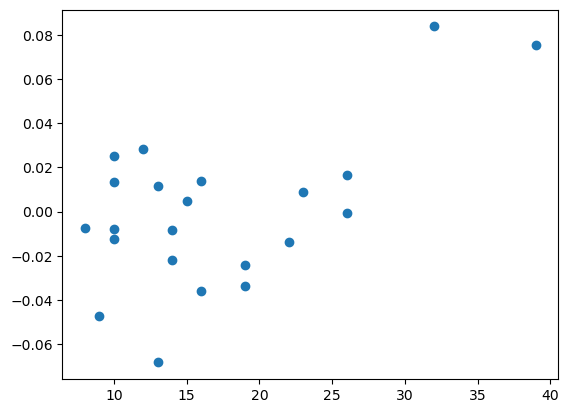

In [74]:
plt.scatter(bdi_list,cpe_betas)

In [75]:
formula = 'logRT_t1 ~ 1 + reg_t'
re_formula = 'reg_t'

cpe_rt_model = smf.mixedlm(formula=formula,data = rt_choice_pred_df, groups=rt_choice_pred_df['subj_id'], 
                       re_formula=re_formula).fit()
print(cpe_rt_model.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [76]:
formula = 'logRT_t1 ~ 1 + rel_t'
re_formula = 'rel_t'

cpe_rt_model = smf.mixedlm(formula=formula,data = rt_choice_pred_df, groups=rt_choice_pred_df['subj_id'], 
                       re_formula=re_formula).fit()
print(cpe_rt_model.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [77]:
formula = 'logRT_t1 ~ 1 + C(choice_t1) + cpe_t'
re_formula = 'C(choice_t1) + cpe_t'

cpe_rt_model = smf.mixedlm(formula=formula,data = rt_choice_pred_df, groups=rt_choice_pred_df['subj_id'], 
                       re_formula=re_formula).fit()
print(cpe_rt_model.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [78]:
formula = 'logRT_t1 ~ 1 + C(choice_t) + cpe_t'
re_formula = 'C(choice_t) + cpe_t'

cpe_rt_model = smf.mixedlm(formula=formula,data = rt_choice_pred_df, groups=rt_choice_pred_df['subj_id'], 
                       re_formula=re_formula).fit()
print(cpe_rt_model.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [79]:
formula = 'logRT_t1 ~ 1 + C(type_t1) + cpe_t'
re_formula = 'C(type_t1) + cpe_t'

cpe_rt_model = smf.mixedlm(formula=formula,data = rt_choice_pred_df, groups=rt_choice_pred_df['subj_id'], 
                       re_formula=re_formula).fit()
print(cpe_rt_model.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [80]:
formula = 'logRT_t1 ~ 1 + C(type_t) + cpe_t'
re_formula = 'C(type_t) + cpe_t'

cpe_rt_model = smf.mixedlm(formula=formula,data = rt_choice_pred_df, groups=rt_choice_pred_df['subj_id'], 
                       re_formula=re_formula).fit()
print(cpe_rt_model.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [18]:
formula = 'logRT_t1 ~ 1 + profit_t + cpe_t'
re_formula = 'profit_t + cpe_t'

cpe_rt_model = smf.mixedlm(formula=formula,data = rt_choice_pred_df, groups=rt_choice_pred_df['subj_id'], 
                       re_formula=re_formula).fit()
print(cpe_rt_model.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [82]:
formula = 'logRT_t1 ~ 1 + rpe_t + cpe_t'
re_formula = ' rpe_t + cpe_t'

cpe_rt_model = smf.mixedlm(formula=formula,data = rt_choice_pred_df, groups=rt_choice_pred_df['subj_id'], 
                       re_formula=re_formula).fit()
print(cpe_rt_model.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [20]:
formula = 'logRT_t1 ~ 1 + gamEV_t1 + cpe_t'
re_formula = 'gamEV_t1 + cpe_t'

cpe_rt_model = smf.mixedlm(formula=formula,data = rt_choice_pred_df, groups=rt_choice_pred_df['subj_id'], 
                       re_formula=re_formula).fit()
print(cpe_rt_model.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [83]:
formula = 'logRT_t1 ~ 1 + C(choice_t1) + gamEV_t1 + cpe_t'
re_formula = ' C(choice_t1)  + gamEV_t1 + cpe_t'

cpe_rt_model = smf.mixedlm(formula=formula,data = rt_choice_pred_df, groups=rt_choice_pred_df['subj_id'], 
                       re_formula=re_formula).fit()
print(cpe_rt_model.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Continuous Regressors Model


In [84]:
rt_choice_pred_df.columns

Index(['subj_id', 'epoch_t', 'epoch_t1', 'choice_t1', 'logRT_t1', 'type_t',
       'choice_t', 'outcome_t', 'profit_t', 'cpe_t', 'reg_t', 'rel_t', 'rpe_t',
       'gamEV_t', 'type_t1', 'safe_t1', 'high_t1', 'low_t1', 'gamEV_t1'],
      dtype='object')

In [85]:
# formula for mlm

full_formula = 'logRT_t1 ~ 1 + C(choice_t1) + gamEV_t1 + profit_t + cpe_t'
full_rand_slopes = 'C(choice_t1) + gamEV_t1 + profit_t  + cpe_t'

# full_formula = 'logRT_t1 ~ 1 + C(choice_t) + profit_t + cpe_t + gamEV_t1'
# full_rand_slopes = '~ 1 + C(choice_t) + profit_t + cpe_t + gamEV_t1'

# full_formula = 'logRT_t1 ~ 1 + C(choice_t1) + profit_t + rpe_t + cpe_t'
# full_rand_slopes = '~ 1 + C(choice_t1) + profit_t + rpe_t + cpe_t'


In [86]:
full_rt_model = smf.mixedlm(formula=full_formula,data = rt_choice_pred_df, groups=rt_choice_pred_df['subj_id'], 
                       re_formula=full_rand_slopes)
full_rt_fit = full_rt_model.fit()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [87]:
print(full_rt_fit.summary())

                   Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       logRT_t1  
No. Observations:        3036          Method:                   REML      
No. Groups:              22            Scale:                    0.1163    
Min. group size:         65            Log-Likelihood:           -1145.6915
Max. group size:         149           Converged:                Yes       
Mean group size:         138.0                                             
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         1.091    0.058 18.867 0.000  0.978  1.205
C(choice_t1)[T.2]                -0.034    0.022 -1.539 0.124 -0.076  0.009
gamEV_t1                         -0.083    0.015 -5.607 0.000 -0.113 -0.054
profit_t                       

In [88]:
group_int = full_rt_fit.fe_params[0]
cpe_group_beta = full_rt_fit.fe_params['cpe_t']

In [89]:
# rt_fit.random_effects['DA023']

rand_effects_df = []
rand_reg_lines = {}


for subj_idx, subj_id in enumerate(subj_list):
    subj_bdi = bdi_list[subj_idx]
    subj_int = full_rt_fit.random_effects[subj_id]['Group'] #random intercept 
    subj_cpe_beta = full_rt_fit.random_effects[subj_id]['cpe_t'] #random beta coeff for subj 
    subj_rand_df = pd.DataFrame({'subj_id':subj_id,'subj_bdi':subj_bdi,'rand_int':subj_int,'rand_cpe_beta':subj_cpe_beta},index=[0])
    rand_effects_df.append(subj_rand_df)
    rand_reg_lines[subj_id] = ((cpe_group_beta+subj_cpe_beta)* rt_choice_pred_df['cpe_t'][rt_choice_pred_df['subj_id']==subj_id]) + (subj_int+group_int)
rand_effects_df = pd.concat(rand_effects_df).reset_index().drop(columns='index')

rand_effects_df


subj_id  subj_bdi  rand_int  rand_cpe_beta
0    MS002        14 -0.362586      -0.007282
1    MS003         8  0.122736      -0.004007
2    MS009        16 -0.149821      -0.006414
3    MS011        13  0.162072      -0.020595
4    MS015        26  0.191819       0.013263
5    MS016        10  0.425370       0.002019
6    MS017        26  0.026447       0.005009
7    MS019        12 -0.075794       0.015624
8    MS022        10  0.473034      -0.022836
9    MS024        16 -0.269795       0.018838
10   MS025        10 -0.227143       0.005318
11   MS026         9  0.419672      -0.026664
12   MS027        22  0.171618      -0.001008
13   MS028        13 -0.252320       0.004725
14   MS029        32 -0.214337       0.037278
15   MS030        19  0.029470      -0.011366
16   MS033        39 -0.054843       0.005908
17   MS035        15  0.218746      -0.004386
18   MS041        10 -0.275517       0.004011
19   MS043        23 -0.395073       0.012043
20   DA023        14 -0.200296      -0.009364
21   DA026        19  0.236540      -0.010114

In [90]:
pearsonr(rand_effects_df.subj_bdi,rand_effects_df.rand_cpe_beta)

PearsonRResult(statistic=0.49805197851175204, pvalue=0.01832805185951592)

In [91]:
spearmanr(rand_effects_df.subj_bdi,rand_effects_df.rand_cpe_beta)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SpearmanrResult(correlation=0.4150873943912305, pvalue=0.05473379156127991)

In [92]:
high_bdi_cpe_beta = rand_effects_df['rand_cpe_beta'][rand_effects_df['subj_bdi']>=20]
low_bdi_cpe_beta = rand_effects_df['rand_cpe_beta'][rand_effects_df['subj_bdi']<20]
ttest_ind(low_bdi_cpe_beta,high_bdi_cpe_beta)

Ttest_indResult(statistic=-2.684555829999642, pvalue=0.014251178276421335)

In [93]:
sm.OLS(endog=rand_effects_df.rand_cpe_beta,exog=sm.add_constant(rand_effects_df.subj_bdi)).fit().summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          rand_cpe_beta   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     6.598
Date:                Thu, 16 May 2024   Prob (F-statistic):             0.0183
Time:                        23:44:26   Log-Likelihood:                 65.248
No. Observations:                  22   AIC:                            -126.5
Df Residuals:                      20   BIC:                            -124.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0156      0.007     -2.333      0.030      -0.029      -0.002
subj_bdi       0.0009      0.000      2.569      0.018       0.000       0.002
==============================================================================
Omnibus:                        1.721   Durbin-Watson:                   2.239
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                1.107
Skew:                           0.238   Prob(JB):                        0.575
Kurtosis:                       2.009   Cond. No.                         45.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 0, 'BDI')

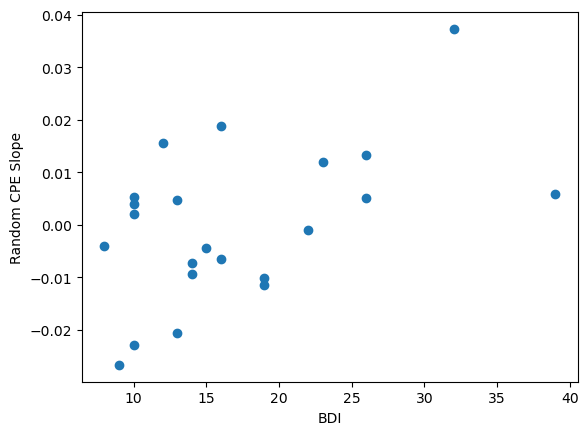

In [94]:
plt.scatter(rand_effects_df.subj_bdi,rand_effects_df.rand_cpe_beta)
plt.ylabel('Random CPE Slope')
plt.xlabel('BDI')

In [62]:
vif_df = pd.DataFrame({'cpe_t':rt_choice_pred_df.cpe_t,
                       'gamEV_t1':rt_choice_pred_df.gamEV_t1,
                       'profit_t':rt_choice_pred_df.profit_t,
                      'choice_t1':rt_choice_pred_df.choice_t1})

vif_df = vif_df.astype(float)


vif_data = pd.DataFrame() 
vif_data["feature"] = vif_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i) 
                          for i in range(len(vif_df.columns))] 

  
print(vif_data)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [26]:
vif_df = pd.DataFrame({'cpe_t':rt_choice_pred_df.cpe_t,
                       'gamEV_t1':rt_choice_pred_df.gamEV_t1,
                       'rpe_t':rt_choice_pred_df.rpe_t,
                       'profit_t':rt_choice_pred_df.profit_t,
                      'type_t1':rt_choice_pred_df.type_t1})

vif_df = vif_df.astype(float)


vif_data = pd.DataFrame() 
vif_data["feature"] = vif_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i) 
                          for i in range(len(vif_df.columns))] 

  
print(vif_data)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [78]:
vif_df = pd.DataFrame({'cpe_t':rt_choice_pred_df.cpe_t,
                       'gamEV_t1':rt_choice_pred_df.gamEV_t1,
                       'rpe_t':rt_choice_pred_df.rpe_t,
                       'profit_t':rt_choice_pred_df.profit_t,
                      'choice_t':rt_choice_pred_df.choice_t})

vif_df = vif_df.astype(float)


vif_data = pd.DataFrame() 
vif_data["feature"] = vif_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i) 
                          for i in range(len(vif_df.columns))] 

  
print(vif_data)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# All Regressor Model

In [95]:
# formula for mlm

full_formula = 'logRT_t1 ~ 1 + C(choice_t) + C(type_t) + C(outcome_t) + profit_t + cpe_t + cf_t + rpe_t + safe_t1 + gamEV_t1 + C(type_t1)'
full_rand_slopes = '~ 1 + C(choice_t) + C(type_t) + C(outcome_t) + profit_t + cpe_t + cf_t + rpe_t + safe_t1 + gamEV_t1 + C(type_t1)'


In [96]:
full_rt_model = smf.mixedlm(formula=full_formula,data = rt_choice_pred_df, groups=rt_choice_pred_df['subj_id'], 
                       re_formula=full_rand_slopes)
full_rt_fit = full_rt_model.fit()


PatsyError: Number of rows mismatch between data argument and cf_t (3036 versus 1)
    ~ 1 + C(choice_t) + C(type_t) + C(outcome_t) + profit_t + cpe_t + cf_t + rpe_t + safe_t1 + gamEV_t1 + C(type_t1)
                                                                      ^^^^

In [97]:
print(full_rt_fit.summary())

                   Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       logRT_t1  
No. Observations:        3036          Method:                   REML      
No. Groups:              22            Scale:                    0.1163    
Min. group size:         65            Log-Likelihood:           -1145.6915
Max. group size:         149           Converged:                Yes       
Mean group size:         138.0                                             
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         1.091    0.058 18.867 0.000  0.978  1.205
C(choice_t1)[T.2]                -0.034    0.022 -1.539 0.124 -0.076  0.009
gamEV_t1                         -0.083    0.015 -5.607 0.000 -0.113 -0.054
profit_t                       

In [34]:
##### test multicollinearity of regressors 
#calculate VIF for every regressor besides outcome vars 

vif_df = rt_choice_pred_df.drop(columns=['subj_id','choice_t1','logRT_t1','high_t1'])
vif_df = vif_df.astype(float)


vif_data = pd.DataFrame() 
vif_data["feature"] = vif_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i) 
                          for i in range(len(vif_df.columns))] 

  
print(vif_data)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# RT CPE Final Model 

relevant resources - 
- https://jinhyuncheong.com/jekyll/update/2021/03/20/How_to_run_LMER_in_Python.html 
- https://www.statsmodels.org/0.9.0/examples/notebooks/generated/mixed_lm_example.html
- https://duchesnay.github.io/pystatsml/statistics/lmm/lmm.html
- https://cims.nyu.edu/~brenden/courses/labincp/chapters/15/00-mixed-effect.html
- https://www.kaggle.com/code/ojwatson/mixed-models/notebook
- https://disease-progression-modelling.github.io/pages/notebooks/disease_course_mapping/TP1_LMM.html
- https://www.pythonfordatascience.org/mixed-effects-regression-python/
- https://medium.com/@josef.waples/linear-mixed-effect-models-in-python-using-mtcars-064c6c3e5b32
- https://edwardlib.org/tutorials/linear-mixed-effects-models
- https://jbhender.github.io/Stats506/F18/GP/Group16.html
- https://www.cl.uni-heidelberg.de/statnlpgroup/empirical_methods/kreutzer_significance-python.html
- https://github.com/junpenglao/GLMM-in-Python/blob/master/GLMM_in_python.ipynb
- https://stats.stackexchange.com/questions/51186/what-would-be-an-illustrative-picture-for-linear-mixed-models/51187#51187
- https://towardsdatascience.com/generalized-linear-mixed-effects-models-in-r-and-python-with-gpboost-89297622820c
- https://support.minitab.com/en-us/minitab/help-and-how-to/statistical-modeling/anova/how-to/mixed-effects-model/interpret-the-results/key-results/


#paper for methods - Newton-Raphson and EM Algorithms for Linear Mixed-Effects Models for Repeated-Measures Data

In [98]:
#### run condensed model - will converge 
formula = 'logRT_t1 ~ 1 + C(choice_t) + profit_t + cpe_t + C(type_t1) + gamEV_t1'
rand_slopes = '~ 1 + C(choice_t) + profit_t + cpe_t + C(type_t1) + gamEV_t1'


In [99]:
rt_model = MixedLM.from_formula(formula=formula,data = rt_choice_pred_df, groups=rt_choice_pred_df['subj_id'], 
                       re_formula=rand_slopes)
rt_fit = rt_model.fit()
# print(rt_fit.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [100]:
print(rt_fit.summary())

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         logRT_t1  
No. Observations:          3036            Method:                     REML      
No. Groups:                22              Scale:                      0.1122    
Min. group size:           65              Log-Likelihood:             -1107.3139
Max. group size:           149             Converged:                  Yes       
Mean group size:           138.0                                                 
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               1.187    0.055 21.718 0.000  1.080  1.295
C(choice_t)[T.2]                       -0.009    0.016 -0.593 0.553 -0.041  0.022
C(type_t1)[T.2]                       

In [611]:
rt_fit.fe_params

Intercept           1.157903
C(choice_t)[T.1]   -0.000826
C(type_t1)[T.2]    -0.092976
C(type_t1)[T.3]    -0.211064
profit_t           -0.007062
cpe_t               0.020020
gamEV_t1           -0.009381
dtype: float64

<Axes: >

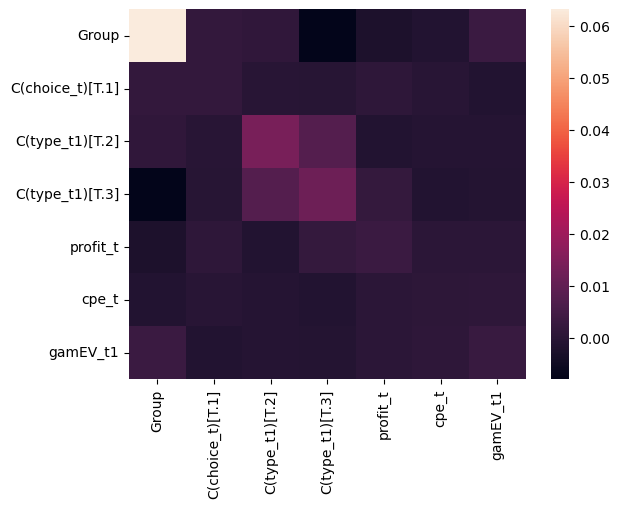

In [612]:
sns.heatmap(rt_fit.cov_re)

<Axes: >

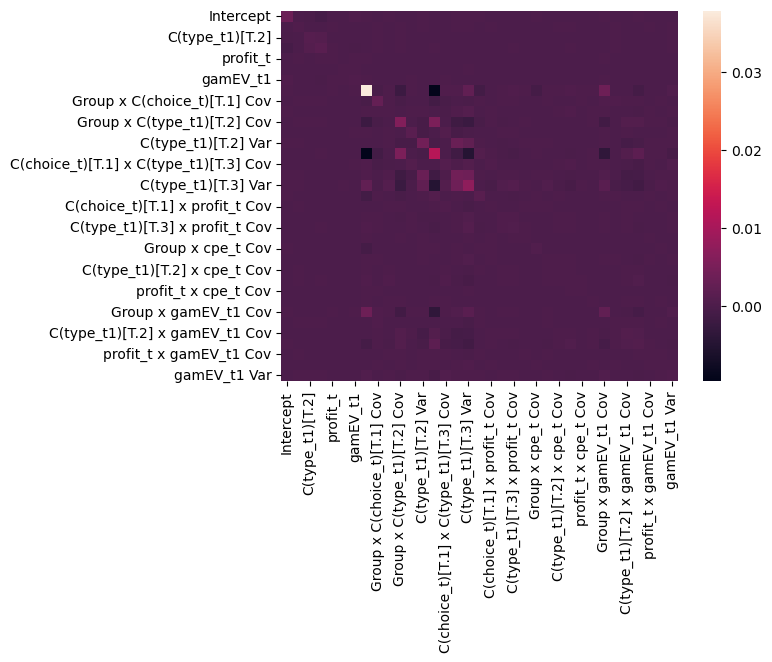

In [613]:
sns.heatmap(rt_fit.cov_params())

In [614]:
rt_fit.cov_re 

Group  C(choice_t)[T.1]  C(type_t1)[T.2]  \
Group             0.063220          0.001611         0.001226   
C(choice_t)[T.1]  0.001611          0.001687        -0.000175   
C(type_t1)[T.2]   0.001226         -0.000175         0.013828   
C(type_t1)[T.3]  -0.007852         -0.000570         0.007722   
profit_t         -0.002413          0.000898        -0.001461   
cpe_t            -0.001432         -0.000186        -0.000661   
gamEV_t1          0.003242         -0.001328        -0.000842   

                  C(type_t1)[T.3]  profit_t     cpe_t  gamEV_t1  
Group                   -0.007852 -0.002413 -0.001432  0.003242  
C(choice_t)[T.1]        -0.000570  0.000898 -0.000186 -0.001328  
C(type_t1)[T.2]          0.007722 -0.001461 -0.000661 -0.000842  
C(type_t1)[T.3]          0.011893  0.001949 -0.001334 -0.001042  
profit_t                 0.001949  0.003130  0.000250  0.000318  
cpe_t                   -0.001334  0.000250  0.000675  0.000879  
gamEV_t1                -0.001042  0.000318  0.000879  0.002833

In [615]:
rt_fit.bse_re 

Group Var                                 0.064125
Group x C(choice_t)[T.1] Cov              0.017135
C(choice_t)[T.1] Var                      0.002479
Group x C(type_t1)[T.2] Cov               0.025674
C(choice_t)[T.1] x C(type_t1)[T.2] Cov    0.012009
C(type_t1)[T.2] Var                       0.021157
Group x C(type_t1)[T.3] Cov               0.035652
C(choice_t)[T.1] x C(type_t1)[T.3] Cov    0.009202
C(type_t1)[T.2] x C(type_t1)[T.3] Cov     0.021179
C(type_t1)[T.3] Var                       0.028234
Group x profit_t Cov                      0.011102
C(choice_t)[T.1] x profit_t Cov           0.003799
C(type_t1)[T.2] x profit_t Cov            0.006133
C(type_t1)[T.3] x profit_t Cov            0.007779
profit_t Var                              0.003797
Group x cpe_t Cov                         0.007427
C(choice_t)[T.1] x cpe_t Cov              0.001837
C(type_t1)[T.2] x cpe_t Cov               0.003919
C(type_t1)[T.3] x cpe_t Cov               0.003769
profit_t x cpe_t Cov           

In [616]:
rt_fit.random_effects

{'MS002': Group              -0.305353
 C(choice_t)[T.1]    0.025840
 C(type_t1)[T.2]    -0.072087
 C(type_t1)[T.3]    -0.002483
 profit_t            0.003516
 cpe_t              -0.012484
 gamEV_t1           -0.075195
 dtype: float64,
 'MS003': Group               0.132398
 C(choice_t)[T.1]   -0.029233
 C(type_t1)[T.2]    -0.009241
 C(type_t1)[T.3]    -0.011802
 profit_t           -0.033742
 cpe_t              -0.007785
 gamEV_t1            0.022118
 dtype: float64,
 'MS004': Group              -0.262994
 C(choice_t)[T.1]   -0.004002
 C(type_t1)[T.2]    -0.001461
 C(type_t1)[T.3]     0.143690
 profit_t            0.082052
 cpe_t              -0.000235
 gamEV_t1            0.005274
 dtype: float64,
 'MS009': Group              -0.132523
 C(choice_t)[T.1]   -0.034927
 C(type_t1)[T.2]    -0.020914
 C(type_t1)[T.3]    -0.009314
 profit_t           -0.054906
 cpe_t              -0.008530
 gamEV_t1           -0.012444
 dtype: float64,
 'MS011': Group               0.136238
 C(choice_t)[T.1]

In [29]:
len(rt_choice_pred_df[rt_choice_pred_df.subj_id == 'MS002'])

146

In [617]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_df = pd.DataFrame({'cpe_t':rt_choice_pred_df.cpe_t,
                       'gamEV_t1':rt_choice_pred_df.gamEV_t1,
                       'type_t1':rt_choice_pred_df.type_t1,
                       'profit_t':rt_choice_pred_df.profit_t,
                      'choice_t':rt_choice_pred_df.choice_t})
# vif_df = rt_choice_pred_df.drop(columns=['subj_id','choice_t1','logRT_t1','type_t','outcome_t','profit_t','cf_t','rpe_t','safe_t1','high_t1','low_t1'])
vif_df = vif_df.astype(float)

vif_data = pd.DataFrame() 
vif_data["feature"] = vif_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i) 
                          for i in range(len(vif_df.columns))] 

  
print(vif_data)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Visualize 

In [618]:
rt_fit.params


Intercept                                 1.157903
C(choice_t)[T.1]                         -0.000826
C(type_t1)[T.2]                          -0.092976
C(type_t1)[T.3]                          -0.211064
profit_t                                 -0.007062
cpe_t                                     0.020020
gamEV_t1                                 -0.009381
Group Var                                 0.580422
Group x C(choice_t)[T.1] Cov              0.014792
C(choice_t)[T.1] Var                      0.015486
Group x C(type_t1)[T.2] Cov               0.011259
C(choice_t)[T.1] x C(type_t1)[T.2] Cov   -0.001603
C(type_t1)[T.2] Var                       0.126950
Group x C(type_t1)[T.3] Cov              -0.072088
C(choice_t)[T.1] x C(type_t1)[T.3] Cov   -0.005234
C(type_t1)[T.2] x C(type_t1)[T.3] Cov     0.070891
C(type_t1)[T.3] Var                       0.109193
Group x profit_t Cov                     -0.022155
C(choice_t)[T.1] x profit_t Cov           0.008243
C(type_t1)[T.2] x profit_t Cov 

In [619]:
rt_fit.random_effects[subj_id]

Group              -0.425238
C(choice_t)[T.1]   -0.032775
C(type_t1)[T.2]     0.150286
C(type_t1)[T.3]     0.070837
profit_t           -0.056778
cpe_t               0.010167
gamEV_t1           -0.025759
dtype: float64

In [620]:
rt_fit.fe_params

Intercept           1.157903
C(choice_t)[T.1]   -0.000826
C(type_t1)[T.2]    -0.092976
C(type_t1)[T.3]    -0.211064
profit_t           -0.007062
cpe_t               0.020020
gamEV_t1           -0.009381
dtype: float64

In [101]:
group_int = rt_fit.fe_params[0]
cpe_group_beta = rt_fit.fe_params['cpe_t']

In [102]:
# rt_fit.random_effects['DA023']

rand_effects_df = []
rand_reg_lines = {}


for subj_idx, subj_id in enumerate(subj_list):
    subj_bdi = bdi_list[subj_idx]
    subj_int = rt_fit.random_effects[subj_id]['Group'] #random intercept 
    subj_cpe_beta = rt_fit.random_effects[subj_id]['cpe_t'] #random beta coeff for subj 
    subj_rand_df = pd.DataFrame({'subj_id':subj_id,'subj_bdi':subj_bdi,'rand_int':subj_int,'rand_cpe_beta':subj_cpe_beta},index=[0])
    rand_effects_df.append(subj_rand_df)
    rand_reg_lines[subj_id] = ((cpe_group_beta+subj_cpe_beta)* rt_choice_pred_df['cpe_t'][rt_choice_pred_df['subj_id']==subj_id]) + (subj_int+group_int)
rand_effects_df = pd.concat(rand_effects_df).reset_index().drop(columns='index')

rand_effects_df


subj_id  subj_bdi  rand_int  rand_cpe_beta
0    MS002        14 -0.309871      -0.008887
1    MS003         8  0.112869      -0.007202
2    MS009        16 -0.154223      -0.006733
3    MS011        13  0.112855      -0.020114
4    MS015        26  0.183634       0.007897
5    MS016        10  0.370135       0.007644
6    MS017        26  0.024014       0.014647
7    MS019        12 -0.187862       0.011228
8    MS022        10  0.434465      -0.026444
9    MS024        16 -0.128971       0.009912
10   MS025        10 -0.054611      -0.001365
11   MS026         9  0.364570      -0.032284
12   MS027        22  0.112431      -0.007932
13   MS028        13 -0.271856       0.010749
14   MS029        32 -0.158562       0.048964
15   MS030        19  0.018862      -0.020375
16   MS033        39 -0.003427       0.035476
17   MS035        15  0.223159      -0.009681
18   MS041        10 -0.309035      -0.007300
19   MS043        23 -0.441624       0.014127
20   DA023        14 -0.177370       0.006915
21   DA026        19  0.240419      -0.019242

In [103]:
pearsonr(rand_effects_df.subj_bdi,rand_effects_df.rand_cpe_beta)

PearsonRResult(statistic=0.6715680429870884, pvalue=0.0006209263421537994)

In [104]:
spearmanr(rand_effects_df.subj_bdi,rand_effects_df.rand_cpe_beta)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SpearmanrResult(correlation=0.4859698046356346, pvalue=0.02184421509008291)

In [105]:
high_bdi_cpe_beta = rand_effects_df['rand_cpe_beta'][rand_effects_df['subj_bdi']>=20]
low_bdi_cpe_beta = rand_effects_df['rand_cpe_beta'][rand_effects_df['subj_bdi']<20]
ttest_ind(low_bdi_cpe_beta,high_bdi_cpe_beta)

Ttest_indResult(statistic=-3.439600103329196, pvalue=0.002593182917571)

In [106]:
sm.OLS(endog=rand_effects_df.rand_cpe_beta,exog=sm.add_constant(rand_effects_df.subj_bdi)).fit().summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          rand_cpe_beta   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     16.43
Date:                Thu, 16 May 2024   Prob (F-statistic):           0.000621
Time:                        23:45:23   Log-Likelihood:                 62.634
No. Observations:                  22   AIC:                            -121.3
Df Residuals:                      20   BIC:                            -119.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0276      0.008     -3.682      0.001      -0.043      -0.012
subj_bdi       0.0016      0.000      4.053      0.001       0.001       0.002
==============================================================================
Omnibus:                        2.078   Durbin-Watson:                   2.302
Prob(Omnibus):                  0.354   Jarque-Bera (JB):                1.072
Skew:                          -0.030   Prob(JB):                        0.585
Kurtosis:                       1.920   Cond. No.                         45.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 0, 'BDI')

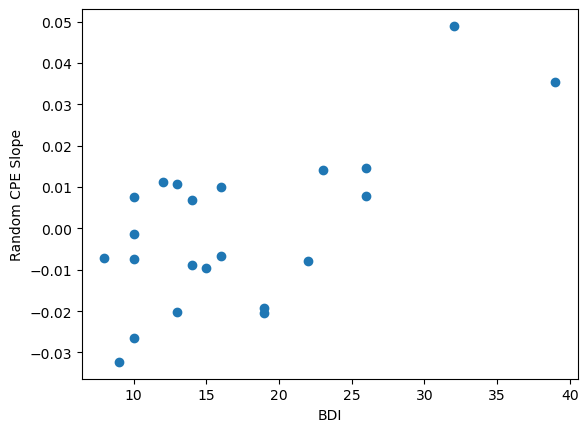

In [107]:
plt.scatter(rand_effects_df.subj_bdi,rand_effects_df.rand_cpe_beta)
plt.ylabel('Random CPE Slope')
plt.xlabel('BDI')

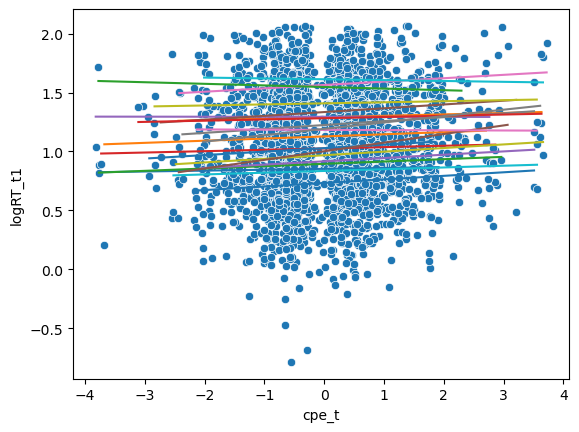

In [628]:
fig, ax = plt.subplots()


sns.scatterplot(ax=ax,x=rt_choice_pred_df.cpe_t,y=rt_choice_pred_df.logRT_t1,legend=False)
for subj_id in subj_list: 
    x = rt_choice_pred_df['cpe_t'][rt_choice_pred_df['subj_id']==subj_id]
    y = rand_reg_lines[subj_id]
    sns.lineplot(ax=ax,x=x,y=y)

In [629]:
b0 = rt_fit.params['Intercept'] #intercept
bcpe = rt_fit.params['cpe_t']
group_y = bcpe*rt_choice_pred_df.cpe_t + b0


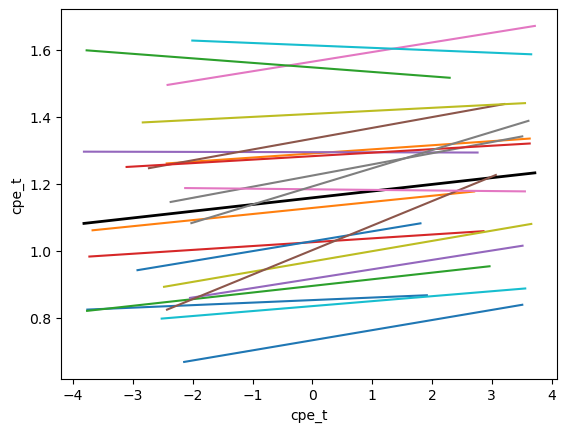

In [630]:
fig, ax = plt.subplots()

#plot overall reg line 

sns.lineplot(ax=ax,x=rt_choice_pred_df.cpe_t,y=group_y,lw=2,color='k')
for subj_id in subj_list: 
    x = rt_choice_pred_df['cpe_t'][rt_choice_pred_df['subj_id']==subj_id]
    y = rand_reg_lines[subj_id]
    sns.lineplot(ax=ax,x=x,y=y,dashes=True)

In [37]:
#### check VIF for neural GLM
# from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = rt_choice_pred_df.drop(columns=['subj_id','choice_t1','logRT_t1','type_t1','outcome_t','profit_t','cf_t','rpe_t','safe_t1','high_t1','low_t1','gamEV_t1'])

vif_df = vif_df.astype(float)

vif_data = pd.DataFrame() 
vif_data["feature"] = vif_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i) 
                          for i in range(len(vif_df.columns))] 

  
print(vif_data)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
    feature       VIF
0    type_t  1.120170
1  choice_t  1.106043
2     cpe_t  1.001147
3   gamEV_t  1.197307
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel on

# Neural regression match

In [531]:
#### run condensed model - will converge 

formula = 'logRT_t1 ~ C(choice_t) + profit_t + cpe_t'
rand_slopes = '~ C(choice_t) + profit_t + cpe_t'

neural_rt_model = MixedLM.from_formula(formula=formula,data = rt_choice_pred_df, groups=rt_choice_pred_df['subj_id'], 
                       re_formula=rand_slopes)
neural_rt_model = neural_rt_model.fit()
# print(rt_fit.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [532]:
print(neural_rt_model.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       logRT_t1  
No. Observations:       2903          Method:                   REML      
No. Groups:             21            Scale:                    0.1238    
Min. group size:        65            Log-Likelihood:           -1161.6208
Max. group size:        149           Converged:                Yes       
Mean group size:        138.2                                             
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        1.053    0.057 18.553 0.000  0.942  1.164
C(choice_t)[T.1]                -0.003    0.015 -0.188 0.851 -0.032  0.027
profit_t                         0.003    0.013  0.205 0.838 -0.023  0.029
cpe_t                            0.018    0.

In [533]:
group_int = neural_rt_model.fe_params[0]
cpe_group_beta = neural_rt_model.fe_params['cpe_t']

In [534]:
# rt_fit.random_effects['DA023']

rand_effects_df = []
rand_reg_lines = {}


for subj_idx, subj_id in enumerate(subj_list):
    subj_bdi = bdi_list[subj_idx]
    subj_int = neural_rt_model.random_effects[subj_id]['Group'] #random intercept 
    subj_cpe_beta = neural_rt_model.random_effects[subj_id]['cpe_t'] #random beta coeff for subj 
    subj_rand_df = pd.DataFrame({'subj_id':subj_id,'subj_bdi':subj_bdi,'rand_int':subj_int,'rand_cpe_beta':subj_cpe_beta},index=[0])
    rand_effects_df.append(subj_rand_df)
    rand_reg_lines[subj_id] = ((cpe_group_beta+subj_cpe_beta)* rt_choice_pred_df['cpe_t'][rt_choice_pred_df['subj_id']==subj_id]) + (subj_int+group_int)
rand_effects_df = pd.concat(rand_effects_df).reset_index().drop(columns='index')

rand_effects_df


subj_id  subj_bdi  rand_int  rand_cpe_beta
0    MS002        14 -0.311837      -0.000909
1    MS003         8  0.119330      -0.005904
2    MS004         7 -0.215743       0.009737
3    MS009        16 -0.142102      -0.007989
4    MS011        13  0.165129      -0.024514
5    MS015        26  0.111736       0.002092
6    MS016        10  0.415324      -0.003267
7    MS017        26  0.063193      -0.001383
8    MS019        12 -0.144025       0.012420
9    MS022        10  0.479533      -0.017002
10   MS024        16 -0.236291       0.008549
11   MS025        10 -0.163100       0.007322
12   MS026         9  0.418609      -0.025294
13   MS027        22  0.210746      -0.010191
14   MS028        13 -0.258092       0.008564
15   MS029        32 -0.192767       0.030553
16   MS030        19  0.056666      -0.011738
17   MS033        39 -0.014496       0.020645
18   MS035        15  0.241446      -0.004219
19   MS041        10 -0.260170       0.003023
20   MS043        23 -0.343088       0.009505

In [535]:
pearsonr(rand_effects_df.subj_bdi,rand_effects_df.rand_cpe_beta)

PearsonRResult(statistic=0.4858988904562384, pvalue=0.02553599937702162)

In [536]:
spearmanr(rand_effects_df.subj_bdi,rand_effects_df.rand_cpe_beta)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SpearmanrResult(correlation=0.27127729836655023, pvalue=0.23424530651839826)

In [537]:
high_bdi_cpe_beta = rand_effects_df['rand_cpe_beta'][rand_effects_df['subj_bdi']>=20]
low_bdi_cpe_beta = rand_effects_df['rand_cpe_beta'][rand_effects_df['subj_bdi']<20]
ttest_ind(low_bdi_cpe_beta,high_bdi_cpe_beta)

Ttest_indResult(statistic=-1.9059416795444144, pvalue=0.0719008775433605)

In [538]:
sm.OLS(endog=rand_effects_df.rand_cpe_beta,exog=sm.add_constant(rand_effects_df.subj_bdi)).fit().summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          rand_cpe_beta   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     5.872
Date:                Mon, 08 Apr 2024   Prob (F-statistic):             0.0255
Time:                        18:55:32   Log-Likelihood:                 63.473
No. Observations:                  21   AIC:                            -122.9
Df Residuals:                      19   BIC:                            -120.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0131      0.006     -2.169      0.043      -0.026      -0.000
subj_bdi       0.0008      0.000      2.423      0.026       0.000       0.001
==============================================================================
Omnibus:                        1.775   Durbin-Watson:                   2.262
Prob(Omnibus):                  0.412   Jarque-Bera (JB):                1.030
Skew:                          -0.145   Prob(JB):                        0.597
Kurtosis:                       1.954   Cond. No.                         41.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 0, 'BDI')

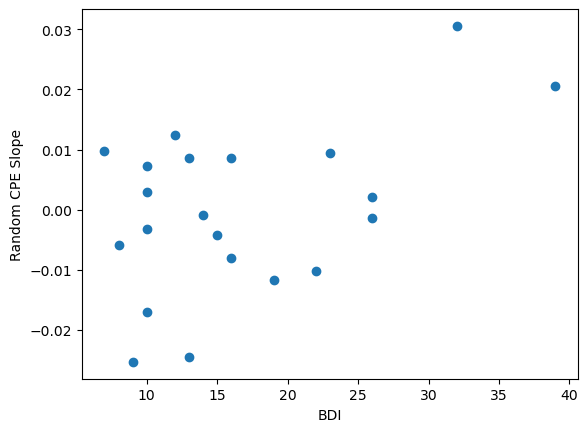

In [539]:
plt.scatter(rand_effects_df.subj_bdi,rand_effects_df.rand_cpe_beta)
plt.ylabel('Random CPE Slope')
plt.xlabel('BDI')